# Web Scraping and Data Wrangling

Import the necessary libraries for Data Analysis

In [1]:
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
import geocoder
import folium

Get the content of the website containing <b>Quezon City's</b> zipcodes.

In [2]:
result = requests.get("http://www.lhiza.com/zipcodes/quezonci.htm")
content = result.content

Initialize beautifulsoup and insert the content of the site as the parameter.

In [3]:
soup = BeautifulSoup(content)

Find the first table and find all the table rows after the first row(the first row is just the table header) inside the table and create a dataframe containing the location along with their corresponding zip code.

In [4]:
codes = soup.findAll('table')[0].findAll('tr')[1:]
l = []
for code in codes:
    place = code.findAll('td')
    l.append({
        'Location': place[0].string,
        'Code': place[1].string
    })
df = pd.DataFrame(l)

Look at the shape of the dataframe and print the first five rows.

In [5]:
print(df.shape)
df.head()

(148, 2)


,Code,Location
0,1105,Alicia
1,1102,Amihan
2,1106,Apolonio Samson
3,1106,Baesa
4,1116,Bagbag


There are 148 rows of location-zipcode pairs.

We'll then use geocoder to utilize arcgis inorder to retrieve the latitude and longitude of the zipcodes in Quezon City. After that, we'll add the longitude and latitudes to the original dataframe.

In [6]:
for i in range(len(df)):
    postcode = df.iloc[i]['Code']
    g = geocoder.arcgis('{}, Philippines'.format(postcode))
    lat_lng_coords = g.latlng
    df_index = df.index[i]
    df.loc[df_index, 'Latitude'] = lat_lng_coords[0]
    df.loc[df_index, 'Longitude'] = lat_lng_coords[1]
df.head()

,Code,Location,Latitude,Longitude
0,1105,Alicia,14.651771,121.025405
1,1102,Amihan,14.629034,121.058258
2,1106,Apolonio Samson,14.662860,121.006515
3,1106,Baesa,14.662860,121.006515
4,1116,Bagbag,14.690154,121.036538


Since some areas or locations in the dataframe have equal latitudes and longtiudes, we drop those duplicates from the dataframe. The number of rows drop down to only 29 rows of unique latitudes and longtiudes.

In [7]:
df = df.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')
df.shape

(29, 4)

We create a folium map that's centered at the latitude and longitude to where <b>Vasra</b>, a location within Quezon City belongs to. We then loop through each location in the dataframe and plot out a blue circle of radius 500 in each location's latitude and longitude.

In [8]:
g = geocoder.arcgis('1128, Philippines')
lat_lng_coords = g.latlng
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

quezon_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, location, code in zip(df['Latitude'], df['Longitude'], df['Location'], df['Code']):
    label = '{}, {}'.format(location, code)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(quezon_map)  
    
quezon_map

Create the variables that'll be sent as parameters to the Foursquare api later.

In [9]:
CLIENT_ID = 'XPB5FXZMOQCI4NEKWCYKFJLXY2YHLVJFTLMCIILNMYQ4QE2A' # your Foursquare ID
CLIENT_SECRET = 'OIDL41IS2T4ITL5J2ZXNP40PPTTAOF5AYTEU5JJEH0UV4QXY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 500
radius = 500

Your credentails:
CLIENT_ID: XPB5FXZMOQCI4NEKWCYKFJLXY2YHLVJFTLMCIILNMYQ4QE2A
CLIENT_SECRET:OIDL41IS2T4ITL5J2ZXNP40PPTTAOF5AYTEU5JJEH0UV4QXY


Create the function that'll call the Foursquare api with the variables created earlier as additional parameters, the call will retrieve the venues of "Food" category, it'll print the locations wherein there are no venues nearby. The function will return a dataframe containing each restaurant found along with their category, location, latitude and longitude.

In [10]:
def get_restaurants(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL filtering by Food Category
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['venues']
        except KeyError:
            print("no restaurants: {} ".format(name))
            continue;
            
        if len(results) == 0:
            print("no restaurants: {} ".format(name))
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name'])])
            except IndexError:
                print("Index Error: {}".format(v['name']))

    nearby_restaurants = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_restaurants.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_restaurants)

Call the function created and pass the dataframe containing the Quezon City postcodes and locations along with the radius while saving the returned dataframe to the variable quezon_restaurants.

In [11]:
quezon_restaurants = get_restaurants(names=df['Location'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'],
                                radius=radius
                                )

no restaurants: Fairview 


With Fairview having no restaurants nearby, we'll remove that row from the dataframe as it will be of no use in the modeling later.

In [12]:
df = df[df['Location'] != 'Fairview']
df.shape

(28, 4)

Display the first five rows of the quezon_restaurants dataframe.

In [13]:
quezon_restaurants.head()

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alicia,14.651771,121.025405,kambingan sa 7,14.652898,121.025525,Filipino Restaurant
1,Alicia,14.651771,121.025405,Starbucks Coffee,14.650880,121.028822,Coffee Shop
2,Alicia,14.651771,121.025405,SamboKojin West Avenue,14.653567,121.029655,Buffet
3,Alicia,14.651771,121.025405,Mushroomburger,14.648712,121.028500,Burger Joint
4,Alicia,14.651771,121.025405,Teresita's of San Fernando,14.651728,121.023400,Filipino Restaurant


Display the last five rows of the quezon_restaurants dataframe.

In [14]:
quezon_restaurants.tail()

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1077,New Era,14.681195,121.058876,Brewing Pit (Isawan),14.676697,121.061601,BBQ Joint
1078,New Era,14.681195,121.058876,The Keithchen,14.678314,121.054711,Food
1079,New Era,14.681195,121.058876,Razon's of Guagua - UP Technohub,14.680815,121.056423,Filipino Restaurant
1080,New Era,14.681195,121.058876,Merry Moo,14.681878,121.055063,Ice Cream Shop
1081,New Era,14.681195,121.058876,PB Co.,14.676671,121.059306,Coffee Shop


Using matplotlib, we'll create a horizontal bar plot that plots the frequency of restaurant categories in the quezon_restaurants dataframe.

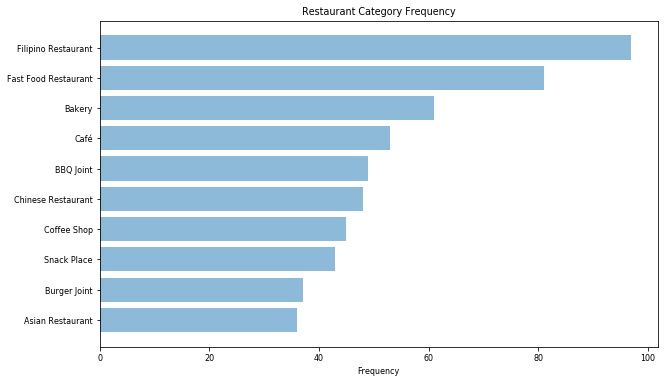

In [43]:
restaurant_cat = quezon_restaurants['Venue Category'].value_counts()
restaurants = list(restaurant_cat.index[0:10])
y_pos = np.arange(len(restaurants))
frequency = restaurant_cat[0:10]

plt.barh(y_pos, frequency, align='center', alpha=0.5)
plt.yticks(y_pos, restaurants)
plt.xlabel('Frequency')
plt.title('Restaurant Category Frequency')
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = (10, 6)
plt.show()

Filipino restaurants are shown to be the most frequent restaurant category with almost a hundred instances, closely followed by Fast food restaurants, then by bakeries.

We'll then perform one-hot encoding on the <b>Venue Category</b> column, which implies the category of the restaurant for later use in clustering. 

In [18]:
# one hot encoding
quezon_onehot = pd.get_dummies(quezon_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
quezon_onehot['Location'] = quezon_restaurants['Location'] 

# move location column to the first column
fixed_columns = [quezon_onehot.columns[-1]] + list(quezon_onehot.columns[:-1])
quezon_onehot = quezon_onehot[fixed_columns]

quezon_onehot.head()

,Location,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bistro,Breakfast Spot,Bubble Tea Shop,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alicia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We'll then group rows together by location, getting the mean of each category for each location, which would then imply weight of the category's frequency for that said location.

In [19]:
quezon_grouped = quezon_onehot.groupby('Location').mean().reset_index()
quezon_grouped.head()

,Location,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bistro,Breakfast Spot,Bubble Tea Shop,...,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wings Joint
0,Alicia,0.0,0.000000,0.040000,0.0,0.040000,0.000000,0.0,0.0,0.040000,...,0.0,0.080000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02
1,Amihan,0.0,0.041667,0.062500,0.0,0.125000,0.000000,0.0,0.0,0.020833,...,0.0,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,Apolonio Samson,0.0,0.000000,0.000000,0.0,0.000000,0.052632,0.0,0.0,0.052632,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,BF Homes,0.0,0.000000,0.029412,0.0,0.058824,0.000000,0.0,0.0,0.029412,...,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Bagbag,0.0,0.037037,0.037037,0.0,0.037037,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


Just to visualize each location's most common restaurant category near it, we'll create a function that returns the <b>n</b> most common restaurant categories near it. We'll then create a dataframe with the column 'Location' along with the top 5 most common restaurant categories near the location, and we'll call this dataframe, quezon_sorted.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
quezon_sorted = pd.DataFrame(columns=columns)
quezon_sorted['Location'] = quezon_grouped['Location']

for ind in np.arange(quezon_grouped.shape[0]):
    quezon_sorted.iloc[ind, 1:] = return_most_common_venues(quezon_grouped.iloc[ind, :], num_top_venues)

print(quezon_sorted.shape)
quezon_sorted.head()

(28, 6)


,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alicia,Filipino Restaurant,Fast Food Restaurant,Tea Room,Snack Place,Chinese Restaurant
1,Amihan,Fast Food Restaurant,Bakery,Tea Room,Food Truck,BBQ Joint
2,Apolonio Samson,Café,Pizza Place,Filipino Restaurant,Chinese Restaurant,Fast Food Restaurant
3,BF Homes,Filipino Restaurant,Snack Place,Korean Restaurant,Comfort Food Restaurant,Coffee Shop
4,Bagbag,Filipino Restaurant,Fast Food Restaurant,Diner,Donut Shop,Fish & Chips Shop


# Modeling and Evaluation


K-Means Clustering will be performed on the dataframe, removing Location from the dataframe so that the data will solely be the weights of the categories.

One of the problems in K-means Clustering is finding the proper K as a parameter. To find the proper K, we'll use the elbow method to find the number of clusters to use for our clustering.

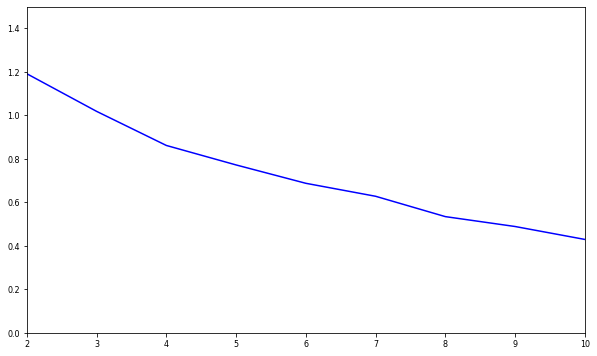

In [44]:
num_of_cluster = range(2,11)
x = range(2, 11)
y = []
y_silhouette = []
quezon_grouped_clustering = quezon_grouped.drop('Location', 1)
for kclusters in num_of_cluster:
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(quezon_grouped_clustering)
    label = kmeans.labels_
    y.append(abs(kmeans.score(quezon_grouped_clustering)))
    y_silhouette.append(silhouette_score(quezon_grouped_clustering, label, metric='euclidean'))
plt.plot(x, y, 'b-')
plt.axis([2, 10, 0, 1.5])
plt.show()

There is no clear elbow point in the plot above when using the "within-cluster sum-of-squares criterion" or "inertia" as the score. We'll then show the plot again but now using the "silhouette-score" as our score.

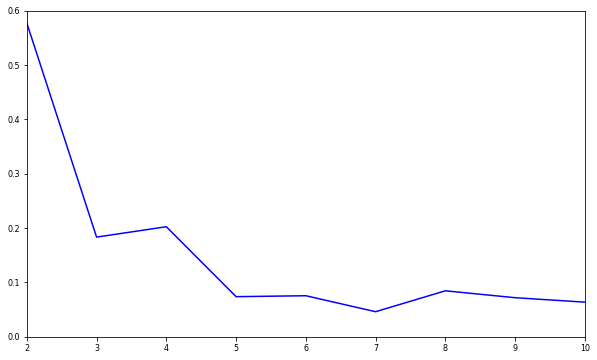

In [48]:
plt.plot(x, y_silhouette, 'b-')
plt.axis([2, 10, 0, 0.6])
plt.show()

With the silhouette score as the score basis, our elbow point is at 5, so we'll choose 5 as our optimum number of clusters to use. 

We'll then perform K-means clustering again with 5 as the cluster parameter.

In [23]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(quezon_grouped_clustering)
kmeans.labels_[0:10] 

array([0, 3, 0, 4, 4, 0, 3, 3, 1, 4], dtype=int32)

We'll now add the cluster labels to the quezon_sorted dataframe(the dataframe which contains the location and the top 5 most common restaurant venues near it). 

We'll also add 1 to our cluster label so that the first cluster starts at cluster 1 instead of 0 which improves readability.

In [24]:
# add clustering labels
quezon_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

quezon_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
quezon_merged = quezon_merged.join(quezon_sorted.set_index('Location'), on='Location').reset_index()

quezon_merged['Cluster Labels'] += 1
quezon_merged.head() # check the last columns!

,index,Code,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,1105,Alicia,14.651771,121.025405,1,Filipino Restaurant,Fast Food Restaurant,Tea Room,Snack Place,Chinese Restaurant
1,1,1102,Amihan,14.629034,121.058258,4,Fast Food Restaurant,Bakery,Tea Room,Food Truck,BBQ Joint
2,2,1106,Apolonio Samson,14.662860,121.006515,1,Café,Pizza Place,Filipino Restaurant,Chinese Restaurant,Fast Food Restaurant
3,4,1116,Bagbag,14.690154,121.036538,5,Filipino Restaurant,Fast Food Restaurant,Diner,Donut Shop,Fish & Chips Shop
4,5,1109,Bagong Buhay,14.620135,121.063451,4,BBQ Joint,Burger Joint,Asian Restaurant,Dim Sum Restaurant,Restaurant


We'll know create and show the folium map which shows the same map as before but now showing different colors for each circle according to their cluster membership.

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 2, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(quezon_merged['Latitude'], quezon_merged['Longitude'], quezon_merged['Location'], quezon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

We'll then look at what locations belong to each cluster and show a vertical bar graph that depicts the top 5 most frequent restaurant categories within the cluster.

The cluster names are based on their top most frequent restaurant category, if the scores are close enough to each other for the top 1,2,3 and so on, the category name will be concatenated to each other to form the cluster name.

We'll first look at Cluster 1 - Filipino Restaurant/Fast Food/Cafe Cluster.

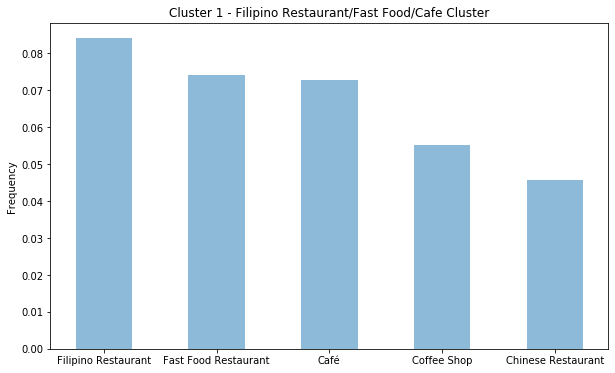

,Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1105,1,Filipino Restaurant,Fast Food Restaurant,Tea Room,Snack Place,Chinese Restaurant
2,1106,1,Café,Pizza Place,Filipino Restaurant,Chinese Restaurant,Fast Food Restaurant
7,1110,1,BBQ Joint,Filipino Restaurant,Fast Food Restaurant,Snack Place,Chinese Restaurant
11,1101,1,Café,Filipino Restaurant,Mexican Restaurant,Ramen Restaurant,Bubble Tea Shop
13,1100,1,Fast Food Restaurant,Coffee Shop,Diner,Restaurant,Pizza Place
16,1104,1,Filipino Restaurant,Fast Food Restaurant,Chinese Restaurant,Korean Restaurant,Café
17,1112,1,Snack Place,Coffee Shop,Café,Filipino Restaurant,Breakfast Spot
21,1122,1,BBQ Joint,Filipino Restaurant,Café,Burger Joint,Coffee Shop
22,1114,1,Korean Restaurant,Chinese Restaurant,Bakery,Fast Food Restaurant,Bubble Tea Shop
23,1127,1,Café,Korean Restaurant,Bubble Tea Shop,BBQ Joint,Bakery


In [26]:
cluster_zero_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 1]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_zero_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_zero_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
frequency = mean_categories[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster 1 - Filipino Restaurant/Fast Food/Cafe Cluster')

plt.show()


quezon_merged.loc[quezon_merged['Cluster Labels'] == 1, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]]

For cluster 1, we can see that the Filipino Restaurants, Fast food restaurants and cafes all have a nearly similar score.

We'll then look at Cluster 2 - Japanese Restaurant/Coffee Shop Cluster.

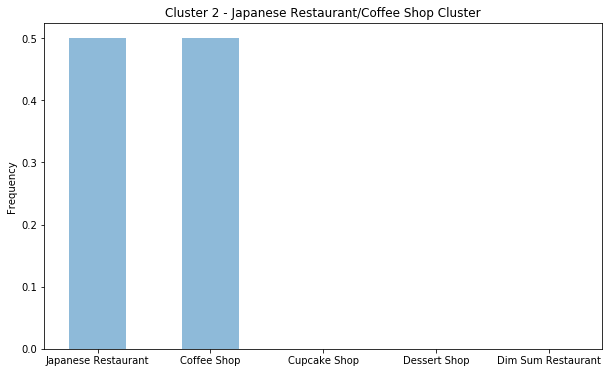

,Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,1119,2,Japanese Restaurant,Coffee Shop,Cupcake Shop,Dessert Shop,Dim Sum Restaurant


In [27]:
cluster_two_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 2]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_two_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_two_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
frequency = mean_categories[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster 2 - Japanese Restaurant/Coffee Shop Cluster')

plt.show()



quezon_merged.loc[quezon_merged['Cluster Labels'] == 2, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]]

We can notice that there's only one member of this cluster maybe due to the fact that the combination of restaurants present in the area is relatively rare and an infrequent instance as compared to the other locations. Japanese Restaurants often utilize seafood in their menu, the location may be a factor as it is close to the sea.

We'll then look at Cluster 3 - Burger Joint Cluster.

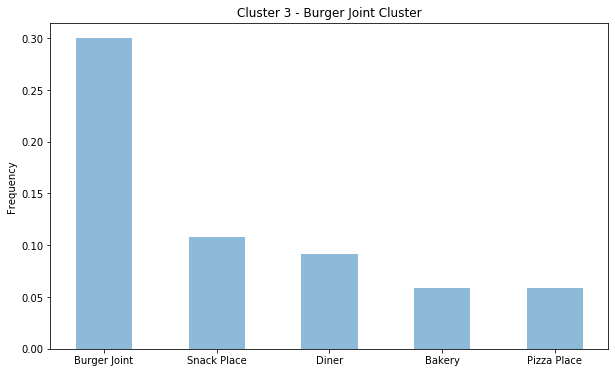

,Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,1117,3,Burger Joint,Snack Place,Fast Food Restaurant,Breakfast Spot,Pizza Place
20,1125,3,Burger Joint,Diner,Soup Place,Pizza Place,Bakery


In [28]:
cluster_three_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 3]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_three_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_three_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
frequency = mean_categories[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster 3 - Burger Joint Cluster')

plt.show()


quezon_merged.loc[quezon_merged['Cluster Labels'] == 3, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]]

In the third cluster, we can notice that burger joints are very common in those locations, those locations may prefer lighter meals as opposed to the regular restaurants that offer main courses. A contributing factor to that insight is that Snack Place is the second most common category in one of the locations within that cluster.

We'll then look at Cluster 4 - Bakery Cluster.

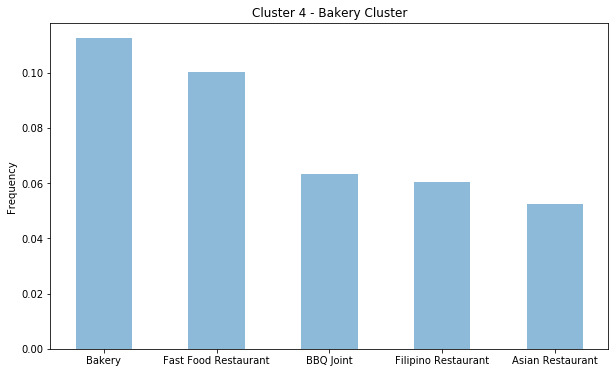

,Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,1102,4,Fast Food Restaurant,Bakery,Tea Room,Food Truck,BBQ Joint
4,1109,4,BBQ Joint,Burger Joint,Asian Restaurant,Dim Sum Restaurant,Restaurant
5,1111,4,Bakery,Fast Food Restaurant,Asian Restaurant,Fried Chicken Joint,Filipino Restaurant
14,1121,4,Bakery,Breakfast Spot,Fast Food Restaurant,Dessert Shop,Asian Restaurant
15,1128,4,Bakery,Pizza Place,Filipino Restaurant,Ice Cream Shop,Café
18,1123,4,Fast Food Restaurant,Snack Place,Bakery,Burger Joint,Filipino Restaurant
19,1113,4,Bakery,Chinese Restaurant,Diner,Café,Asian Restaurant


In [29]:
cluster_four_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 4]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_four_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_four_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
frequency = mean_categories[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster 4 - Bakery Cluster')

plt.show()



quezon_merged.loc[quezon_merged['Cluster Labels'] == 4, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]]

In the fourth cluster, we can see that bakeries and fast food restaurants are the two most common restaurant categories in those locations. Bakeries and Fast Food Restaurants usually serve their food almost instantaneously, this may be a location that needs to have people to be on the go always and are looking for places to eat with low waiting time.

We'll then look at the last cluster, Cluster 5 - Filipino Restaurant Cluster.

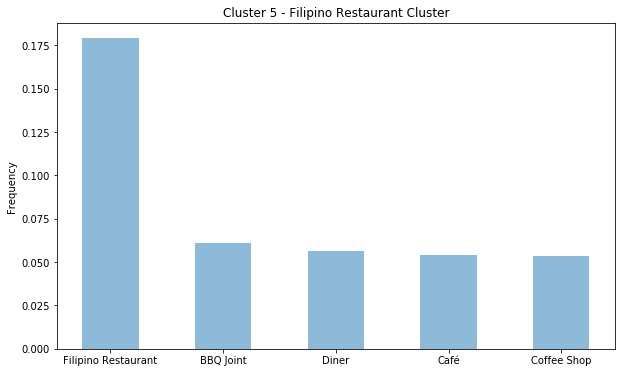

,Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,1116,5,Filipino Restaurant,Fast Food Restaurant,Diner,Donut Shop,Fish & Chips Shop
8,1115,5,Filipino Restaurant,Chinese Restaurant,Asian Restaurant,Bakery,Dessert Shop
9,1126,5,Filipino Restaurant,BBQ Joint,Coffee Shop,Restaurant,Café
10,1120,5,Filipino Restaurant,Snack Place,Korean Restaurant,Comfort Food Restaurant,Coffee Shop
24,1124,5,Filipino Restaurant,Diner,BBQ Joint,Chinese Restaurant,Burger Joint
27,1107,5,Diner,Filipino Restaurant,BBQ Joint,Coffee Shop,Ice Cream Shop


In [30]:
cluster_five_members = quezon_merged.loc[quezon_merged['Cluster Labels'] == 5]
summed_means = quezon_grouped[quezon_grouped['Location'].isin(cluster_five_members['Location'])].sum()[1:]
mean_categories = (summed_means/len(cluster_four_members)).sort_values(ascending=False)

restaurants = list(mean_categories.index[0:5])
y_pos = np.arange(len(restaurants))
frequency = mean_categories[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster 5 - Filipino Restaurant Cluster')

plt.show()



quezon_merged.loc[quezon_merged['Cluster Labels'] == 5, quezon_merged.columns[[1] + list(range(5, quezon_merged.shape[1]))]]

Locations in this cluster usually have Filipino Restaurants being the top most common and frequent restaurants. People in those locations may prefer more traditional types of dining.

Let's then look at a chart containing the frequency of clusters within Quezon City.

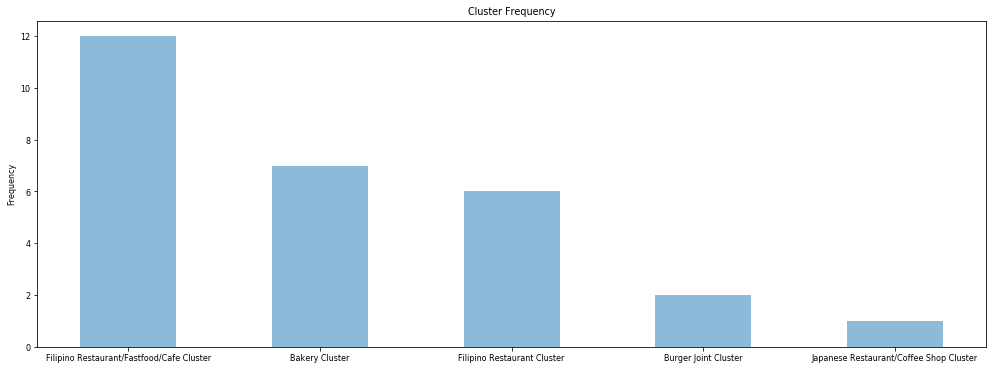

In [33]:
values = quezon_merged['Cluster Labels'].value_counts()
restaurants = ['Filipino Restaurant/Fastfood/Cafe Cluster',
               'Bakery Cluster',
               'Filipino Restaurant Cluster',
               'Burger Joint Cluster',
               'Japanese Restaurant/Coffee Shop Cluster']
y_pos = np.arange(len(restaurants))
frequency = values[0:5]

plt.bar(y_pos, frequency, align='center', alpha=0.5, width=0.5)
plt.xticks(y_pos, restaurants)
plt.ylabel('Frequency')
plt.title('Cluster Frequency')
plt.rc('font', size=8)
plt.rcParams['figure.figsize'] = (17, 6)

plt.show()

We can see that the first cluster, the <b>Filipino Restaurant/Fastfood/Cafe Cluster</b> has the most locations belonging to that cluster. While the <b>Bakery Cluster</b> and the <b>Filipino Restaurant Cluster</b> have a small difference in frequency between each other. Followed by the <b>Burger Joint Cluster</b> and the <b>Japanese Restaurant/Coffee Shop Cluster</b> making up the least amount of locations falling inside those clusters.

It is evident that Filipino Restaurants are frequently present inside Quezon City locations, but the fact that Quezon City is inside the Philippines could be an obvious factor as to why.